<img src="../images/whatsapp_leonardo_ai.jpg" width="650">,

# **Analizando un grupo de WhatsApp**

## 1 Introducción

En esta notebook se explora el comportamiento de un grupo de WhatsApp a lo largo del tiempo. Empezaremos limpiando y organizando los datos, creando un DataFrame con información sobre **fecha y hora de los mensajes**, **quién los envió** (anonimizado) y **su contenido**.

Después realizaremos un **análisis exploratorio**, respondiendo preguntas como:

* ¿Quiénes son los miembros más activos del grupo?
* ¿Cuándo se envían más mensajes a lo largo del día y de la semana?
* ¿Cómo cambia la actividad a lo largo del semestre o del año?
* ¿Qué palabras se usan más y qué nos dicen sobre el tipo de conversación del grupo?

Finalmente, haremos algunos **análisis adicionales** para entender patrones interesantes, como quién manda mensajes más largos o más cortos, y cómo varía la participación entre los miembros.


### 1.1 Configuraciones de entorno

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

import re
import zipfile
from pathlib import Path

In [2]:
plt.style.use('ggplot')

Los directorios de datos: 

In [3]:
BASE = Path().resolve().parent
DATA = BASE / "data"
RAW = DATA / "raw"
PROCESSED = DATA / "processed"

In [4]:
BASE.exists(), BASE.is_dir()

(True, True)

Aseguramos que los directorios están presentes en el proyecto: 

In [5]:
RAW.mkdir(exist_ok=True, parents=True)
PROCESSED.mkdir(exist_ok=True, parents=True)

## 2 Ingesta de Datos

Los datos han sido descargados directamente desde un gurpo de WhatsApp y colocados en `data/raw` con el nombre de `grupo.zip`. 

Verifiquemos que los datos están presentes: 

In [6]:
for item in RAW.iterdir():
    if item.suffix == '.zip': 
        print(item.relative_to(BASE))

data\raw\grupo.zip


Creamos el apuntador al archivo y verificamos que existe y que es un archivo válido: 

In [7]:
zfile = RAW / "grupo.zip"

zfile.exists(), zfile.is_file()

(True, True)

El archivo de salida: 

In [8]:
outpath = RAW / "grupo.txt"

Para extraer el archivo `ZIP` usamos el paquete `zipfile`: 

In [9]:
with zipfile.ZipFile(zfile, 'r') as file:
    filename = file.namelist()[0]

    with file.open(filename) as source: 
        with open(outpath, 'wb') as target:
            target.write(source.read())

Verificamos que el archivo se ha extraido correctamente: 

In [10]:
outpath.exists(), outpath.is_file()

(True, True)

Una vez extraido podemos cambiamos de manualmente los nombres de los participantes. En total hay 6 participantes en el grupo y se han usado nombres de los superheroes de la liga de la justicia: Batman, Aquaman, Superman, Wonder Woman y Linterna Verde). 

El archivo de texto con los nombres modificados está en la dirección `data/raw/grupo_no_names.txt`

Ahora, cargamos el archivo de texto y demos un vistazo a los datos: 

In [11]:
nonamespath = RAW / "grupo_no_names.txt"
nonamespath.exists(), nonamespath.is_file()

(True, True)

In [12]:
with open(nonamespath, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 10:  # las primeras 20 lineas
            break

10/4/2023, 11:39 - Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.
10/4/2023, 11:39 - ‎Wonder Woman creó el grupo "grupo".
10/4/2023, 11:39 - ‎Wonder Woman te añadió
10/4/2023, 11:40 - Flash: ✋✋✋
10/4/2023, 11:41 - Flash: Rola las fotos Wonder Woman
10/4/2023, 11:41 - Flash: Un parienton
10/4/2023, 11:43 - Wonder Woman: ayuda el Batman está hablando ***
10/4/2023, 11:45 - Batman: Hao✋
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>


Nótese que las primeras líneas del archivo indican la fecha de creación del grupo, el participante que lo creo y la fecha en la que propietario de los datos fue agregado al grupo: `10/04/2023, 11:39`. 

Para procesar el archivo obtenemos una lista con todas las lineas del archivo de texto: 

In [13]:
with open(nonamespath, 'r', encoding="utf-8") as f:
    lines = f.readlines()

In [14]:
len(lines), lines[:5]

(11317,
 ['10/4/2023, 11:39 - Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.\n',
  '10/4/2023, 11:39 - \u200eWonder Woman creó el grupo "grupo".\n',
  '10/4/2023, 11:39 - \u200eWonder Woman te añadió\n',
  '10/4/2023, 11:40 - Flash: ✋✋✋\n',
  '10/4/2023, 11:41 - Flash: Rola las fotos Wonder Woman\n'])

¡Las líneas de texto han sido cargadas correctamente!

Ahora, separamos cada línea como una tupla con los campos `fecha`, `hora`, `usuario`, `mensaje`. 

Para ello, primero conviene analizar la estructura de las líneas: 

In [16]:
for line in lines[:100]: 
    print(line.replace('\n', ''))

10/4/2023, 11:39 - Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.
10/4/2023, 11:39 - ‎Wonder Woman creó el grupo "grupo".
10/4/2023, 11:39 - ‎Wonder Woman te añadió
10/4/2023, 11:40 - Flash: ✋✋✋
10/4/2023, 11:41 - Flash: Rola las fotos Wonder Woman
10/4/2023, 11:41 - Flash: Un parienton
10/4/2023, 11:43 - Wonder Woman: ayuda el Batman está hablando ***
10/4/2023, 11:45 - Batman: Hao✋
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:57 - Flash: <Multimedia omitido>
12/4/2023, 10:34 - Wonder Woman: Flash
12/4/2023, 10:34 - Wonder Woman: y los yashis
12/4/2023, 10:34 - Wonder Woman: <Multimedia omitido>
12/4/2023, 10:34 - Superman: 

Sabemos de antemano que hay 6 participantes en el grupo, cuyas identidades han sido anonimizadas. En estas primeras líneas ya podemos ver a algunos de ellos. Las líneas de los mensajes enviados por los participantes siguen este formato:

* (`fecha`, `hora`, `usuario`, `mensaje`)

Algo que también notamos en esta muestra es que los mensajes largos aparecen divididos en varias líneas.

Por otro lado, los mensajes del sistema de WhatsApp tienen una estructura similar, pero sin incluir el nombre del usuario.

Con estas observaciones, ya podemos comenzar a extraer la información de cada línea y convertirla en tuplas con los datos del mensaje. Para eso, usamos la siguiente función:

In [18]:
def get_fields(lines):
    # Regex para mensajes normales (con usuario)
    msg_pattern = r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)'

    # Regex para mensajes de sistema (sin usuario)
    sys_pattern = r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*)'

    tuples = []
    
    for line in lines:
        line = line.strip()
        msg_match = re.match(msg_pattern, line)
        sys_match = re.match(sys_pattern, line)

        if msg_match:
            # Nuevo mensaje con usuario
            fecha, hora, nombre, contenido = msg_match.groups()
            tuples.append((fecha, hora, nombre, contenido))
        
        elif sys_match:
            # Mensaje del sistema
            fecha, hora, contenido = sys_match.groups()
            tuples.append((fecha, hora, "<Sistema>", contenido))
        
        else:
            # Continuación de mensaje anterior
            if tuples:
                fecha, hora, nombre, contenido = tuples[-1]
                contenido = contenido + " " + line  # concatenamos: linea anterior + linea actual
                tuples[-1] = (fecha, hora, nombre, contenido)    
                
    return tuples


In [20]:
tuple_msgs = get_fields(lines)

for line in tuple_msgs[:10]: 
    print(line)

('10/4/2023', '11:39', '<Sistema>', 'Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.')
('10/4/2023', '11:39', '<Sistema>', '\u200eWonder Woman creó el grupo "grupo".')
('10/4/2023', '11:39', '<Sistema>', '\u200eWonder Woman te añadió')
('10/4/2023', '11:40', 'Flash', '✋✋✋')
('10/4/2023', '11:41', 'Flash', 'Rola las fotos Wonder Woman')
('10/4/2023', '11:41', 'Flash', 'Un parienton')
('10/4/2023', '11:43', 'Wonder Woman', 'ayuda el Batman está hablando ***')
('10/4/2023', '11:45', 'Batman', 'Hao✋')
('10/4/2023', '11:55', 'Flash', '<Multimedia omitido>')
('10/4/2023', '11:55', 'Flash', '<Multimedia omitido>')


¡Los campos de cada línea han sido extraidos correctamente!

Ahora, pasamos los datos de texto a `DataFrame`: 

In [21]:
df = pd.DataFrame(tuple_msgs, columns=['fecha', 'hora', 'usuario', 'mensaje'])

## 3 Limpieza y Procesamiento

Antes de limpar los datos conviene hacer una pequeña exploración del `DataFrame`: 

In [22]:
df.head()

,fecha,hora,usuario,mensaje
0,10/4/2023,11:39,<Sistema>,Los mensajes y las llamadas están cifrados de ...
1,10/4/2023,11:39,<Sistema>,"‎Wonder Woman creó el grupo ""grupo""."
2,10/4/2023,11:39,<Sistema>,‎Wonder Woman te añadió
3,10/4/2023,11:40,Flash,✋✋✋
4,10/4/2023,11:41,Flash,Rola las fotos Wonder Woman


In [23]:
df.dtypes

fecha      object
hora       object
usuario    object
mensaje    object
dtype: object

Es necesario unir la fecha y hora una sola columna `datetime`:

In [24]:
df['datetime'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'], format="%d/%m/%Y %H:%M")
df['datetime'].head()

0   2023-04-10 11:39:00
1   2023-04-10 11:39:00
2   2023-04-10 11:39:00
3   2023-04-10 11:40:00
4   2023-04-10 11:41:00
Name: datetime, dtype: datetime64[ns]

Ahora, analicemos la columna `mensaje` para determinar el tipo de mensaje: 

In [25]:
df['mensaje'].head()

0    Los mensajes y las llamadas están cifrados de ...
1                 ‎Wonder Woman creó el grupo "grupo".
2                              ‎Wonder Woman te añadió
3                                                  ✋✋✋
4                          Rola las fotos Wonder Woman
Name: mensaje, dtype: object

Para evitar errores con mayúsculas, es conveniente normalizar los de mensajes: 

In [26]:
df['mensaje'] = df['mensaje'].str.lower()

Vemos que los elementos multimedia (*stickers*, *videos*, etc.) se identifican con la palabra `<multimedia omitido>`: 

In [28]:
multimedias = df[df['mensaje'].str.contains('multimedia')]
multimedias['mensaje'].unique()

array(['<multimedia omitido>'], dtype=object)

Debido a que se han exportado los mensajes considerando únicamente los mensajes, no es posible saber si el mensaje multimedia es un *audio*, *video*, *imagen*, *documento* ó *sticker*. Por lo que las categorias de tipo de mensaje serán unicamente `texto` y `multimedia`.

Definimos la función clasificadora y posteriormente creamos la columna `tipo` para que cada mensaje tenga asociado su tipo: 

In [29]:
def classify_msg(line): 
    if 'multimedia' in line:
        return 'multimedia'
    else: 
        return 'texto'

In [30]:
df['tipo'] = df['mensaje'].apply(classify_msg)

In [33]:
df['tipo'].head(10)

0         texto
1         texto
2         texto
3         texto
4         texto
5         texto
6         texto
7         texto
8    multimedia
9    multimedia
Name: tipo, dtype: object

¡Los tipos de mensaje se han asociado correctamente!

Ahora, creamos la columna `num_palabras` que almacena la cantidad de palabras en cada mensaje: 

In [35]:
df['num_palabras'] = df['mensaje'].str.split(' ').str.len()

In [37]:
df.head()

,fecha,hora,usuario,mensaje,datetime,tipo,num_palabras
0,10/4/2023,11:39,<Sistema>,los mensajes y las llamadas están cifrados de ...,2023-04-10 11:39:00,texto,25
1,10/4/2023,11:39,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",2023-04-10 11:39:00,texto,6
2,10/4/2023,11:39,<Sistema>,‎wonder woman te añadió,2023-04-10 11:39:00,texto,4
3,10/4/2023,11:40,Flash,✋✋✋,2023-04-10 11:40:00,texto,1
4,10/4/2023,11:41,Flash,rola las fotos wonder woman,2023-04-10 11:41:00,texto,5


Por último, creamos la columna `num_chars` que almacena la cantidad de carácteres de cada mensaje: 

In [38]:
df['num_chars'] = df['mensaje'].str.len()

In [40]:
df.head()

,fecha,hora,usuario,mensaje,datetime,tipo,num_palabras,num_chars
0,10/4/2023,11:39,<Sistema>,los mensajes y las llamadas están cifrados de ...,2023-04-10 11:39:00,texto,25,162
1,10/4/2023,11:39,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",2023-04-10 11:39:00,texto,6,36
2,10/4/2023,11:39,<Sistema>,‎wonder woman te añadió,2023-04-10 11:39:00,texto,4,23
3,10/4/2023,11:40,Flash,✋✋✋,2023-04-10 11:40:00,texto,1,3
4,10/4/2023,11:41,Flash,rola las fotos wonder woman,2023-04-10 11:41:00,texto,5,27


In [41]:
df.dtypes

fecha                   object
hora                    object
usuario                 object
mensaje                 object
datetime        datetime64[ns]
tipo                    object
num_palabras             int64
num_chars                int64
dtype: object

¡La limpieza esta completa!

Reorganicemos las columnas del `DataFrame`: 

In [42]:
df = df[['datetime', 'usuario', 'mensaje', 'tipo', 'num_palabras', 'num_chars']]
df.head()

,datetime,usuario,mensaje,tipo,num_palabras,num_chars
0,2023-04-10 11:39:00,<Sistema>,los mensajes y las llamadas están cifrados de ...,texto,25,162
1,2023-04-10 11:39:00,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",texto,6,36
2,2023-04-10 11:39:00,<Sistema>,‎wonder woman te añadió,texto,4,23
3,2023-04-10 11:40:00,Flash,✋✋✋,texto,1,3
4,2023-04-10 11:41:00,Flash,rola las fotos wonder woman,texto,5,27


Finalmente, guardamos el dataframe ya procesado para su posterior análisis: 

In [43]:
cleanpath = PROCESSED / "grupo_clean.csv"

In [44]:
df.to_csv(cleanpath)

## 4 Análisis Exploratorio de Datos

Primero cargamos el dataset previamente limpiado: 

In [45]:
df = pd.read_csv(cleanpath, index_col=0)

In [46]:
df.head()   # Ok

,datetime,usuario,mensaje,tipo,num_palabras,num_chars
0,2023-04-10 11:39:00,<Sistema>,los mensajes y las llamadas están cifrados de ...,texto,25,162
1,2023-04-10 11:39:00,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",texto,6,36
2,2023-04-10 11:39:00,<Sistema>,‎wonder woman te añadió,texto,4,23
3,2023-04-10 11:40:00,Flash,✋✋✋,texto,1,3
4,2023-04-10 11:41:00,Flash,rola las fotos wonder woman,texto,5,27


Validamos los *types* de cada columna: 

In [47]:
df.dtypes

datetime        object
usuario         object
mensaje         object
tipo            object
num_palabras     int64
num_chars        int64
dtype: object

Solo es necesario *parsear* la columna `datetime`: 

In [48]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [49]:
df.dtypes

datetime        datetime64[ns]
usuario                 object
mensaje                 object
tipo                    object
num_palabras             int64
num_chars                int64
dtype: object

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10769 entries, 0 to 10768
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10769 non-null  datetime64[ns]
 1   usuario       10769 non-null  object        
 2   mensaje       10769 non-null  object        
 3   tipo          10769 non-null  object        
 4   num_palabras  10769 non-null  int64         
 5   num_chars     10769 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 588.9+ KB


¡Correcto!

Observamos que hay 10769 registros y no hay ningún elemento nulo. 

Procedemos a hacer el análisis exploratorio de los datos. 

### 4.1 Estadísticas Descriptivas

Una descripción estadística de las variables numércias: 

In [51]:
df.select_dtypes('int64').describe()

,num_palabras,num_chars
count,10769.000000,10769.000000
mean,4.176897,23.938249
std,5.218570,30.572135
min,1.000000,1.000000
25%,2.000000,11.000000
50%,3.000000,20.000000
75%,5.000000,28.000000
max,219.000000,1385.000000


* El promedio de palabras por mensaje es de 4 con una desviación estándar de 5.

* EL promedio de carácteres por mensaje es de 5 con una desviación estándar de 30. 

* La mayoria de los mensajes poseen entre 2 y 5 palabras y entre 11 y 28 carácteres. 

* El máximo de palabras en un solo mensaje fue de 219 con 1385 carácteres. 

Analicemos los mensajes con un solo carácter: 

In [57]:
df[df['num_palabras'] == 1]['mensaje'].value_counts().head(10).reset_index()

,mensaje,count
0,jajajajaja,62
1,si,47
2,jajajajaj,44
3,?,42
4,smn,41
5,@⁨batman⁩,39
6,@⁨aquaman⁩,37
7,jajajajajaj,32
8,no,31
9,nel,24


Los mensajes de una palabra/caractero son aquellos relacionados a afirmaciones/negaciones y sentencias usadas en contextos de diversión, además de referencias a usuarios (denotadas por `@usuario`). 

Notemos que los usuarios **Batman** y **Aquaman** fueron referenciados en multiples ocasiones: ¿será porque no contestan? 

Ahora consideremos el mensaje más largo de todo el chat: 

In [64]:
max_words = df.loc[df['num_palabras'].idxmax()]
max_words

datetime                                      2023-08-17 18:09:00
usuario                                              Wonder Woman
mensaje         adios cubo en el rincón del saber, el cubo yac...
tipo                                                        texto
num_palabras                                                  219
num_chars                                                    1385
Name: 3411, dtype: object

Vemos que la fecha es de `2023-08-17 18:09:00` y que fue mandado por **Wonder Woman**. 

Analicemos el contenido del mensaje: 

In [66]:
for line in max_words.mensaje.split(','):
    print(line)

adios cubo en el rincón del saber
 el cubo yacía
 un espacio donde el tiempo se desvanecía
 física danzante en el espacio-tiempo enlazada
 nuestros corazones allí encontraban morada. sus paredes resplandecían con ecuaciones en juego
 misterios entrelazados en cada rincón del vuelo
 átomos danzaban en un ballet cuántico sin fin
 y el universo se tejía en un tapiz de quarks y sínfines. era un santuario de ideas donde los estudiantes se unían
 explorando las leyes que el cosmos tejían
 las mentes curiosas convergían en su interior
 como constelaciones que exploran el ancho laboratorio. charlas y debates llenaban el aire con fervor
 donde teorías flotaban como cometas con ardor
 el eco de risas y neuronas que chocaban
 creaban galaxias de pensamiento
 sin tregua
 sin pausa. mas ayer llegó el adiós
 el último capítulo escrito
 el cubo cerró sus puertas
 un universo infinito
 en el reloj de la física
 un suspiro resonó
 el tiempo
 implacable
 su curso inexorable trazó. oh
 cubo querido
 en e

¡El mensaje más largo es un poema!

Interesante, parece que en algún momento **Wonder Woman**  compartió un mensaje cuyo contenido es un poema que evoca tristeza y melancolía dedicado a algún lugar llamado 'el cubo', que parece ser algún aula, salón o laboratorio relacionado al aprendizaje, especialmente de física. 

Me llama la atención la frase *agujero negro de conocimiento*. Normalmente, los agujeros negros consumen y esconden, pero aquí parece simbolizar algo como un centro gravitacional de conocimento, una paradoja que aunque se infiere que 'el cubo' desaparece, su esencia permanece atrayendo memorias y aprendizajes. 

Verifiquemos que los usuarios son los correctos:

In [67]:
users = df['usuario'].unique().tolist()
users

['<Sistema>',
 'Flash',
 'Wonder Woman',
 'Batman',
 'Superman',
 'Aquaman',
 'Linterna Verde']

* Sin contar al **<Sistema>** en el grupo hay 6 usuarios, todos con los nombres de los superheroes de la liga de la Justicia. 

* Recordemos que **\<Sistema\>** son aquellos mensajes relacionados cambios en el grupo: agregar/expulsar miembros, miembros que salen del grupo, cambios de foto del grupo, etc. 

### 4.2 Usuarios más activos

Para analizar la actividad de los usuarios consideremos el total de mensajes por miembro:  

In [68]:
count_mensajes = df['usuario'].value_counts().reset_index()
count_mensajes

,usuario,count
0,Wonder Woman,4140
1,Flash,1833
2,Superman,1785
3,Linterna Verde,1286
4,Aquaman,1138
5,Batman,564
6,<Sistema>,23


!Wonder Woman es el miembro más activo del grupo!

Para obtener información más reprecentativa, obtengamos la relación entre la cantidad de mensajes y el total de mensajes en el grupo: 

In [72]:
total_mensajes = len(df)
print('El total de mensajes en el grupo es: ', total_mensajes)

El total de mensajes en el grupo es:  10769


In [73]:
count_mensajes[r'%'] = count_mensajes['count'] * 100 / total_mensajes 
count_mensajes

,usuario,count,%
0,Wonder Woman,4140,38.443681
1,Flash,1833,17.021079
2,Superman,1785,16.575355
3,Linterna Verde,1286,11.941684
4,Aquaman,1138,10.567369
5,Batman,564,5.237255
6,<Sistema>,23,0.213576


**Wonder Woman**  fue el usuario que más habló y con mucha diferencia con el resto. Por otro lado,  **Batman** fue el miembro con más silencioso.


Un `countplot` del total de mensajes por miembros:

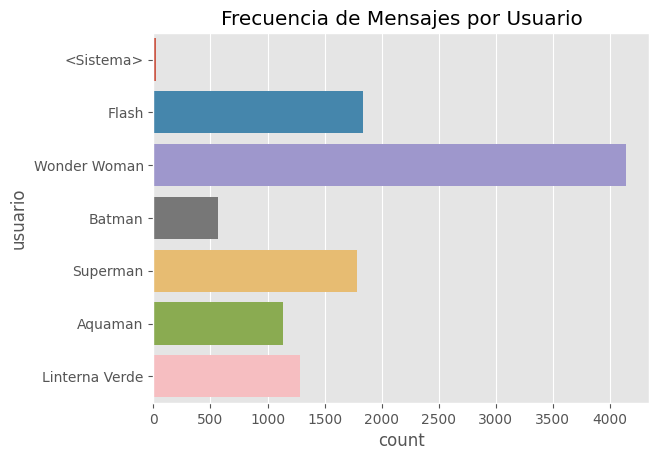

In [74]:
g = sns.countplot(
    data=df,
    y='usuario',
    hue='usuario', 
    # stat='percent'
)
g.set(
    title='Frecuencia de Mensajes por Usuario'
)
plt.show()

En base a los datos del grupo, podemos decir lo siguiente: 

* **Wonder Woman** domina claramente la conversación, con **4140 mensajes**, lo que representa un **38.44%** del total.
    + Es la más **activa** del grupo con diferencia.

* **Flash** y **Superman** le siguen con **1833** (17.02%) y **1785** (16.58%) mensajes, respectivamente.
    + Ambos tienen una participación considerable, aunque cada uno representa menos de la mitad de la actividad de Wonder Woman.

* Luego vienen **Linterna Verde** y **Aquaman**, con una participación **intermedia**:
    + Linterna Verde: 1286 mensajes (11.94%)
    + Aquaman: 1138 mensajes (10.57%)

* **Batman** es el más reservado entre los superhéroes, con solo **564 mensajes** (5.24%).
    + Podría ser considerado el más **callado** del grupo.

### 4.3 Texto vs Multimedia

En el grupo identificaamos dos tipos de mensajes: multimedia y texto. 

Determinemos la cantidad de mensajes por tipo: 

In [85]:
count_tipos = df.groupby('tipo').size().reset_index()
count_tipos.columns = ['tipo', 'count']
count_tipos[r'%'] = count_tipos['count']*100/total_mensajes
count_tipos

,tipo,count,%
0,multimedia,1446,13.427431
1,texto,9323,86.572569


La cantidad de mensajes de tipo multimedia es muy baja comparada con el total de mensajes de texto, reprecenta el 13.5% del total de mensajes en el grupo.

Ahora, observemos la distribución del tipo de mensaje por usuario: 

In [86]:
tabla = (
    df.groupby(['usuario', 'tipo'])['tipo']
      .agg('count')
      .unstack(fill_value=0)
      .reset_index()
)

Tenemos índices multindex que no son muy comodos para trabajar. Podemos eliminarlos como sigue: 

In [87]:
tabla.columns.name = None
tabla

,usuario,multimedia,texto
0,<Sistema>,0,23
1,Aquaman,298,840
2,Batman,26,538
3,Flash,229,1604
4,Linterna Verde,120,1166
5,Superman,339,1446
6,Wonder Woman,434,3706


In [88]:
tabla.columns

Index(['usuario', 'multimedia', 'texto'], dtype='object')

Para reprecentar la información como barras, es necesario convertir a *long-format*. Usamos `pd.melt` como sigue: 

In [92]:
long_tabla = tabla.melt(id_vars="usuario", 
                  value_vars=["multimedia", "texto"], 
                  var_name="tipo", value_name="cantidad")
long_tabla

,usuario,tipo,cantidad
0,<Sistema>,multimedia,0
1,Aquaman,multimedia,298
2,Batman,multimedia,26
3,Flash,multimedia,229
4,Linterna Verde,multimedia,120
5,Superman,multimedia,339
6,Wonder Woman,multimedia,434
7,<Sistema>,texto,23
8,Aquaman,texto,840
9,Batman,texto,538


Con lo anterior, ya podemos graficar los datos y analizar la distribución de los tipos de mensaje por usuario: 

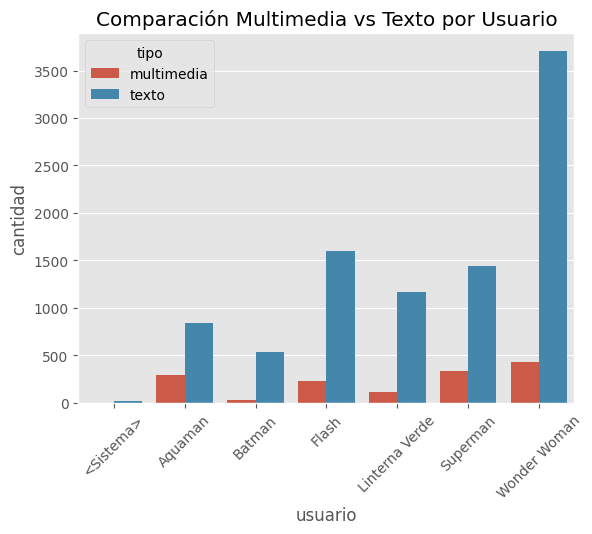

In [93]:
sns.barplot(
    data=long_tabla,
    x="usuario",
    y="cantidad", 
    hue="tipo"
)
plt.xticks(rotation=45)
plt.title("Comparación Multimedia vs Texto por Usuario")
plt.show()


Nuevamente Wonder Woman ha sido el usuario con más mensajes multimedia, pero no con mucha diferencia. Vemos que Aquaman y Superman compartieron una cantidad casí igual a Wonder Woman. De igual forma, batman sigue siendo el miembro más aburrido del grupo, apenas mandó elementos multimedia. 

### 4.3 Ditribución temporal

Primero, identifiquemos la fecha de inicio y la fecha final de los mensajes: 

In [94]:
fecha_inicio = df['datetime'].min()
fecha_final = df['datetime'].max()

In [95]:
print(f'El chat posee mensajes desde {fecha_inicio} hasta {fecha_final}')

El chat posee mensajes desde 2023-04-10 11:39:00 hasta 2024-10-26 18:47:00


Para analizar la distribución temporal de los mensajes, es necesario extraer otras variables de la columna `datetime`, en particular la hora del mensaje y el día de la semana: 

In [96]:
df['hora'] = df['datetime'].dt.hour
df['dia'] = df['datetime'].dt.day_name(locale='es_ES')

In [97]:
df.head()

,datetime,usuario,mensaje,tipo,num_palabras,num_chars,hora,dia
0,2023-04-10 11:39:00,<Sistema>,los mensajes y las llamadas están cifrados de ...,texto,25,162,11,Lunes
1,2023-04-10 11:39:00,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",texto,6,36,11,Lunes
2,2023-04-10 11:39:00,<Sistema>,‎wonder woman te añadió,texto,4,23,11,Lunes
3,2023-04-10 11:40:00,Flash,✋✋✋,texto,1,3,11,Lunes
4,2023-04-10 11:41:00,Flash,rola las fotos wonder woman,texto,5,27,11,Lunes


Los mensajes por hora del día: 

In [102]:
hourly_counts = df.groupby('hora').size().reset_index()
hourly_counts.columns = ['hora', 'count']

In [108]:
hourly_counts

,hora,count
0,0,59
1,1,27
2,2,4
3,3,5
4,4,3
5,5,22
6,6,25
7,7,162
8,8,392
9,9,512


Observemos la distribución por hora mediante un gráfico de barras:

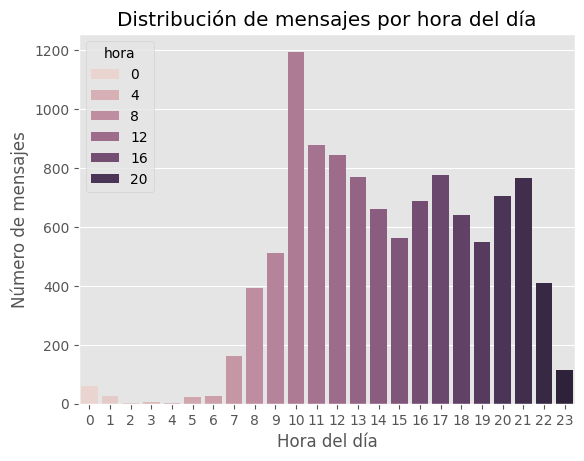

In [107]:
sns.barplot(
    data=hourly_counts,
    x='hora',
    y='count',
    hue='hora'
    )
plt.xlabel("Hora del día")
plt.ylabel("Número de mensajes")
plt.title("Distribución de mensajes por hora del día")
plt.show()

La mayor cantidad de mensajes se registra a las 10 de la mañana. Sin embargo, entre las 10:00 y las 21:00 horas, la cantidad de mensajes por hora se mantiene estable, lo que sugiere una distribución casi uniforme en ese rango de tiempo.

Ahora, contemos los mensajes por día de la semana: 

In [140]:
weekday_counts = df['dia'].value_counts()

Ordenamos naturalmente los días de la semana: 

In [141]:
orden = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]
weekday_counts = weekday_counts.reindex(orden)

In [142]:
weekday_counts = weekday_counts.reset_index()
weekday_counts.columns = ['dia', 'count']

In [144]:
weekday_counts.columns

Index(['dia', 'count'], dtype='object')

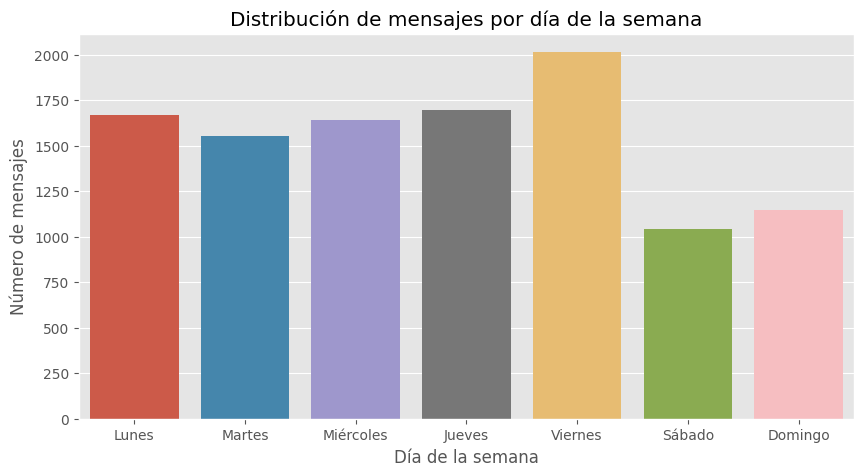

In [145]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=weekday_counts,
    x='dia', 
    y='count',  
    hue='dia', 
)
plt.xlabel("Día de la semana")
plt.ylabel("Número de mensajes")
plt.title("Distribución de mensajes por día de la semana")
plt.show()

La distribución es bastante uniforme, con 1500-1700 mensajes entre semana y aproximadamente 1000 mensajes en total los fines de semana. 

Nótese que el pico se presenta el día veirnes. Con poco más de 2000 mensajes en total. 

### 4.4 Nube de palabras

Una nube de palabras nos permitirá identificar los patrones convesación en el grupo a partir de las palabrás más usadas.

Primero, observemos el wordcloud de todos los mensajes:

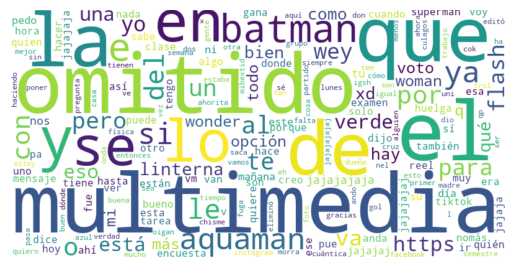

In [146]:
texto = " ".join(df["mensaje"].dropna())

wc = WordCloud(
    width=800, height=400,
    background_color="white",
    collocations=False
).generate(texto)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


La palabra `multimedia` y `omitido` se repite mucho, asdemás de las *stopwords* básicas del idioma español (*la*, *uno*, *yo*, *como*, ect). 

Algo curioso es que **batman** se menciona mucho, pero es el integrante del grupo con menos actividad en el grupo: ¿será porque es el que menos contesta mensajes?


Para desifrar los patrones de conversación quitemos las *stop-words* y las palabras que no reprecentan información: 

In [147]:
from wordcloud import STOPWORDS

**Nota**: No está funcionando el modelo `es_core_news_md`, por lo que se agregarán las stopwords más comunes a mano. 

In [ ]:
# !uv pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.7.0/es_core_news_md-3.7.0-py3-none-any.whl

In [164]:
stopwords_spacy = set(STOPWORDS)

STOPWORDS_ES = {
    "de","la","que","el","en","y","a","los","se","del","las","por","un","para","con",
    "no","una","su","al","es","lo","como","más","mas","pero","sus","le","ya","o","fue","ha",
    "si","sí","cuando","muy","sin","sobre","también","tambien","me","hasta","hay","donde",
    "quien","quienes","desde","todo","todos","nos","durante","uno","les","ni","contra","otros",
    "cual","cuál","era","poco","ella","él","ellos","ellas","este","esta","estos","estas","esto",
    "aquí","aqui","alli","allí","mismo","cada","otro","otra","tan","tanto","tanta","qué","que",
    "porque","porqué","porq","asi","aun","aún","todavia","todavía","entonces","aunque","mientras","hola","buenos",
    "buenas","buen","día","dia","tarde","noche","mi","mis","mio","mía","tu","tú","te","ti",
    "nosotros","vosotros","usted","ustedes","denada","de_nada","pues","lol","lmao","okey","pues", 
    "omitido", "multimedia", "yo", "https",  "batman", "wonder", "woman", "superman", "aquaman", "linterna", "verde", 
    "flash", "va", "esa", "ese", "puede", "oigan", "ser", "bueno", "gente", "hoy", "eso", "esta", 
    "opcion", "está", "dijo", "estoy", "opción", "quien", "dice", "son", "tienen", "ahi", "ahí", "así", 
    "dio", "ver", "ve", "vas", "nomás", "nomas", "quién", "o", "mensaje", "algo"
}

In [165]:
my_stopwords = stopwords_spacy | STOPWORDS_ES

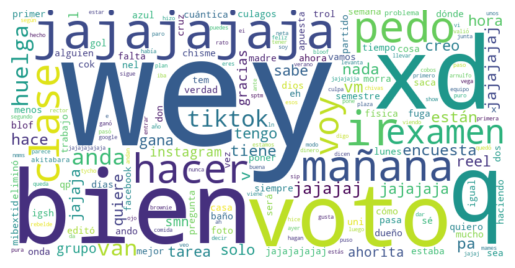

In [166]:
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    stopwords=my_stopwords,
    collocations=False
).generate(texto)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


Vemos que la palabra más mencionada es "**wey**", lo que refleja el tono informal y cercano entre los particpantes. Otros términos que destacan son las relacionadas a **interacciones de risa** como *"jaja"* *"xd"*, así como referencias a redes sociales "tiktok" e "instagram", que probablemente generan las interacciones anteriores. Por otro lado, aparecen palabras asociadas a la **actividad académica** como *"tarea"*, *"examen"*, *"huelga"*, *"problema"*, lo que confirma que gran parte de los mensajes están relacionados a temas escolares. 

### 4.5 ¿Quién escribe los mensajes más largos?

Contamos con las columnas `num_palabras`, `num_chars`. A partir de estas podemos analziar el comportameinto de los participantes del grupo.

Obtenemos la tabla para analizar estas variables: 

In [167]:
df.groupby('usuario')[['num_palabras', 'num_chars']].agg(['mean', 'std'])

num_palabras            num_chars           
                       mean       std       mean        std
usuario                                                    
<Sistema>          4.478261  4.934752  28.782609  31.325210
Aquaman            5.302285  9.263466  30.289104  50.407206
Batman             3.567376  4.156879  20.592199  34.410081
Flash              3.288598  2.462861  19.339880  17.029214
Linterna Verde     4.167963  2.896895  22.493779  14.991708
Superman           4.636415  4.299927  28.610644  26.557540
Wonder Woman       4.146860  5.540527  23.091546  32.129481

Vemos un comportamiento interesante: 

El promedio de palabras por mensaje nos dice que tantas palabras necesita un usuario para expresarse. Entre más alto el promedio, más verboso es el miembro. Vemos que el integrante con el promedio más alto de palabras por mensaje es Aquaman, seguido por Superman y Wonder Woman. Por otro lado, Batman y Flash son los integrantes con menor cantidad de palabras por mensaje. 

La desviación estándar nos dice cuánta variación hay en el tamaño de los mensajes. Los valore altos indican que el usuario a veces manda mensajes muy cortos y a veces muy largos. Podemos agrupar a los usuarios según la variabilidad de longitud de sus mensajes: 

* Usuarios con más variabilidad en el tamaño de mensajes:

    * **Aquaman**: Muy alta variabilidad (9.25 palabras, 50.29 caracteres). Esto sugiere que a veces manda textos largos, otras veces muy cortos.

    * **Wonder Woman**: También tiene variabilidad alta, especialmente en caracteres (32.05).

* Usuarios  con menos variabilidad:

    * **Flash** y **Linterna Verde**: Tienen los valores más bajos de desviación estándar, lo que sugiere un estilo de mensaje más constante y predecible.

    * Flash: 2.46 palabras, 16.99 caracteres.
    * Linterna Verde: 2.89 palabras, 15.00 caracteres.

Batman es el usuario menos participativo, los mensajes son breves y de longitud predecible.

### 4.6 ¿Como cambia la actividad a lo largo del tiempo?

Para analizar la actividad temporal del grupo, agrupamos por mes y verificamos si la epoca del año afecta la actividad. En particular nos centraremos en responder: ¿las vacaciones influyen en la actividad del grupo?

Creamos la columna `year_month`: 

In [172]:
df['year_month_str'] = df['datetime'].dt.strftime('%Y-%m')

In [173]:
df['year_month_str'];  # OK

El total de mensajes por mes: 

In [174]:
mensajes_por_mes = df.groupby('year_month_str').size().reset_index(name='num_mensajes')
mensajes_por_mes.head()  # OK

,year_month_str,num_mensajes
0,2023-04,333
1,2023-05,1226
2,2023-06,1117
3,2023-07,528
4,2023-08,460


Ahora, graficamos los datos obtenidos: 

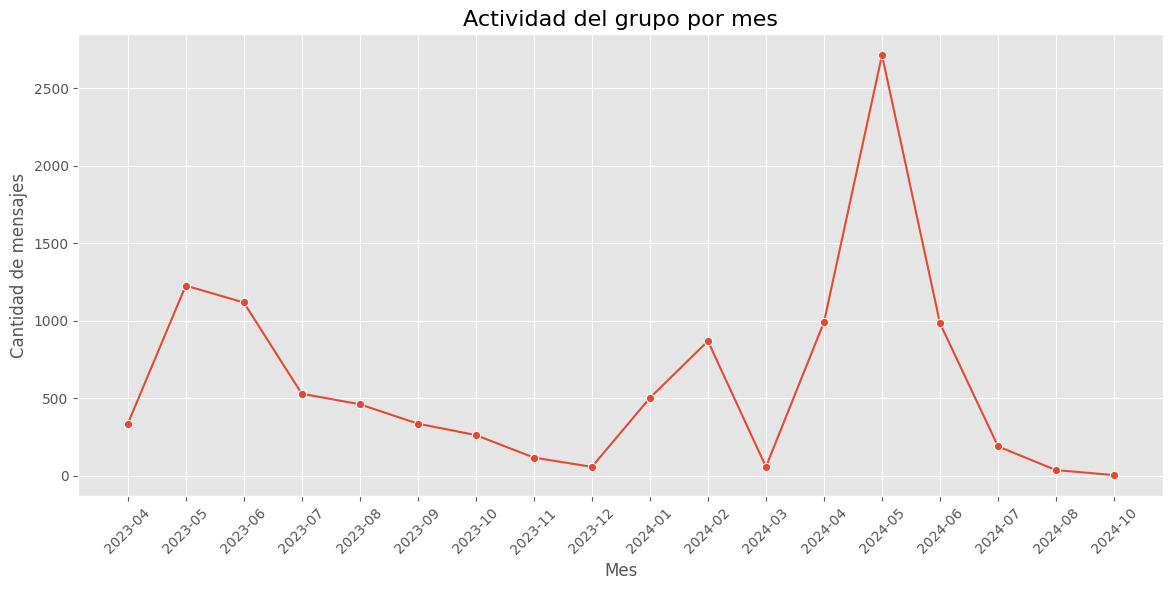

In [175]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=mensajes_por_mes,
    x='year_month_str',
    y='num_mensajes',
    marker='o',
)
plt.title('Actividad del grupo por mes', fontsize=16)
plt.xlabel('Mes')
plt.ylabel('Cantidad de mensajes')
plt.xticks(rotation=45)
plt.show()



Del análisis del *wordcloud* se sugiere que el grupo pertenece a un conjunto de personas con **actividades escolares en común**, ya que aparecen palabras relacionadas con la vida académica como *inscripción*, *grupo*, *tarea*, *examen*, así como palabras como *huelga* y *decisión*. 

El **comportamiento temporal del grupo** es irregular: la cantidad de mensajes no se mantiene constante a lo largo del tiempo, mostrando picos y valles según la época del año y los eventos relevantes.

Considerando el **periodo 2023**, los mensajes alcanzaron su **pico en abril** y se mantuvieron relativamente constantes hasta junio. Esta actividad coincide con el **cierre de semestre**, lo que probablemente influyó en la intensidad de la comunicación. Posteriormente, la cantidad de mensajes disminuyó gradualmente, llegando a casi **cero mensajes por mes en diciembre**, lo que puede relacionarse con las vacaciones.

En el **periodo 2024**, la actividad comenzó de manera intensa, coincidiendo con las **inscripciones escolares a los grupos**, que generaron un aumento en la interacción del grupo. En marzo se observó un **bajón en la actividad**, seguido de un repunte hasta mayo. Durante este año, la actividad académica se ve afectada por **huelgas y la incertidumbre sobre el regreso a clases**, lo que podría explicar la variabilidad de los mensajes.

En general, durante las **vacaciones no se registró una gran actividad**, mientras que los momentos de mayor interacción corresponden a **eventos relevantes del ámbito académico**, como inscripciones, toma de decisiones y conflictos universitarios. Esto indica que el grupo utiliza el grupo para coordinarse y mantenerse informado sobre actividades escolares y asuntos academicos.

## 5 Conclusiones

Del análsis anterior, podemos sacar las siguientes conclusiones:

* El grupo muestra un **comportamiento muy desigual**: Wonder Woman domina la conversación con una alta participación, mientras que Batman es claramente el más reservado. 
 
* La actividad general sigue patrones relacionados con el calendario académico y eventos importantes, con picos de mensajes durante la mañana y los viernes.

* Los mensajes son en promedio breves, aunque algunos miembros como Aquaman y Wonder Woman presentan alta variabilidad en la longitud de sus mensajes, lo que indica que combinan textos cortos y largos.
Las palabras más frecuentes reflejan tanto la vida escolar (*tarea, examen, inscripción, huelga*) como interacciones informales (*wey, jaja, xd, tiktok, instagram*), confirmando que el grupo combina coordinación académica con socialización y diversión.

En conjunto, estos datos muestran un grupo activo y variado, con miembros muy participativos y otros más silenciosos, donde la comunicación se concentra en momentos clave del semestre escolar.